In [1]:
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import openmatrix as omx

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf

ASIM_OUTPUT = r"E:\Met_Council\metc-asim-model\Base_2018\activitysim\output2"
ASIM_CONFIGS_PATH = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'
SURVEY_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
SYNPOP_INPUT = r'E:\Met_Council\metc-asim-model\Input\socioeconomic'
SURVEY_PATH = r'E:\Met_Council\survey_data\Phase2\SPA_Inputs'
CENSUS_SUMMARY_PATH = r'E:\Met_Council\metc-asim-model\Input\Visualizer\census'
SKIM_PATH = r'E:\Met_Council\metc-asim-model\Base_2018\OMX\nmskims.omx'
SKIM_TABLE = 'DIST'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}

# Read model data
tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))
per = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_persons.csv"))

obs_joint_tour_len = pd.read_csv(os.path.join(SURVEY_SUMMARY_PATH, "tourDistProfile_vis.csv")) #.rename(columns = {'freq': 'ObsN'})

omx_file = omx.open_file(SKIM_PATH, 'r')
dist_skim = np.array(omx_file[SKIM_TABLE])
omx_file.close()

nm_tours = tours[tours['tour_category'] == 'atwork'].copy()

nm_tours['distance'] = ((dist_skim[nm_tours['origin'].astype(int) - 1, nm_tours['destination'].astype(int) - 1]).astype(int) + 1).clip(0, 41)

model_tour_len_freq = nm_tours.groupby(['distance']).agg(freq = ('person_id', 'count')).reset_index()


C:\Users\andrew.rohne\AppData\Local\Temp\2\ipykernel_9512\3943333334.py:29: DtypeWarning: Columns (16,28) have mixed types. Specify dtype option on import or set low_memory=False.
  tours = pd.read_csv(os.path.join(ASIM_OUTPUT, "final_tours.csv"))


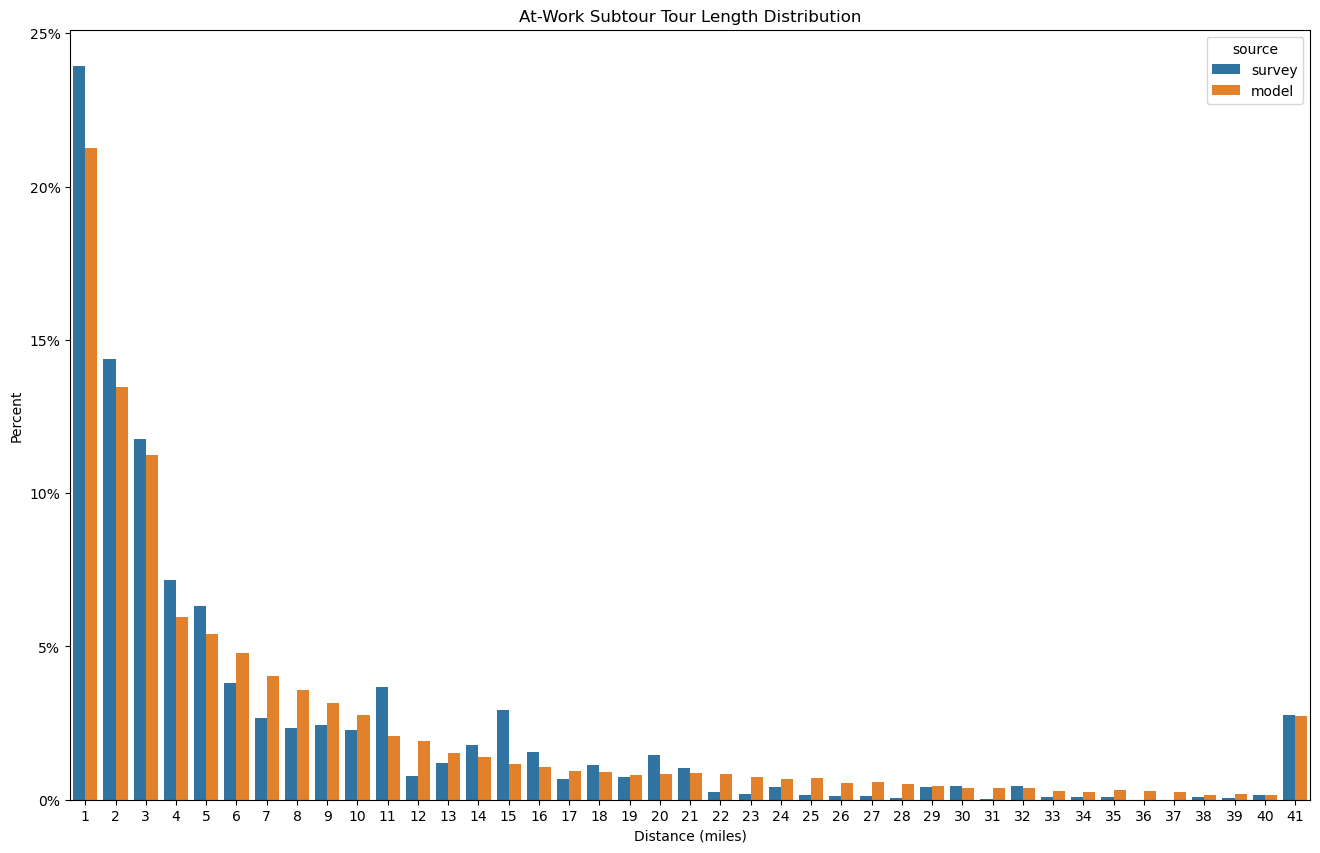

In [2]:
plot_data = pd.concat([obs_joint_tour_len[obs_joint_tour_len['PURPOSE'] == 'atwork'].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
    model_tour_len_freq.assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')])
plot_data['distance'] = plot_data['distance'] 
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
sns.barplot(data = plot_data, x = 'distance', y = 'percent', hue = 'source')
plt.title(f"At-Work Subtour Tour Length Distribution")
# plt.xticks(fontsize=16, rotation = 90)
# plt.yticks(fontsize=16)
plt.ylabel('Percent')
plt.xlabel('Distance (miles)')
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))


In [3]:
x = obs_joint_tour_len[obs_joint_tour_len['PURPOSE'] == 'atwork'].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum())
y = model_tour_len_freq.assign(percent = lambda x: x['freq'] / x['freq'].sum())
cr = x[['distance', 'percent']].set_index('distance').join(y[['distance', 'percent']].set_index('distance'), lsuffix = '_x', rsuffix = '_y').min(1).sum() / x[['distance', 'percent']].set_index('distance').join(y[['distance', 'percent']].set_index('distance'), lsuffix = '_x', rsuffix = '_y').max(1).sum()
print(f"obs ATF: {np.average(x.distance, weights = x.freq):0.2f}, mod ATF: {np.average(y.distance, weights = y.freq):0.2f}, coincidence ratio = {cr:0.2f}")


obs ATF: 7.15, mod ATF: 8.21, coincidence ratio = 0.79


# Adjust Individual Non-Mandatory Tours

In [4]:
adjust_data = pd.concat([obs_joint_tour_len[(obs_joint_tour_len['PURPOSE'] == 'atwork') & (obs_joint_tour_len['distbin'] > 0) & (obs_joint_tour_len['distbin'] <= 20)].rename(columns = {'distbin': 'distance'}).assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'survey'),
        model_tour_len_freq[(model_tour_len_freq['distance'] > 0) & (model_tour_len_freq['distance'] <= 20)].assign(percent = lambda x: x['freq'] / x['freq'].sum(), source = 'model')]).pivot(index = 'distance', columns = 'source', values = 'percent').reset_index()

adjust_data['distance'] = adjust_data['distance'] - 0.5
adjust_data['adjustment'] = np.log(adjust_data['survey'] / adjust_data['model'])
adjust_data


res1 = sm.OLS(endog = adjust_data['adjustment'], exog = adjust_data['distance']).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             adjustment   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.051
Method:                 Least Squares   F-statistic:                            0.02706
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                       0.871
Time:                        08:00:59   Log-Likelihood:                         -10.390
No. Observations:                  20   AIC:                                      22.78
Df Residuals:                      19   BIC:                                      23.77
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.0013      0.008      0.165      0.871      -0.016       0.018
==============================================================================
Omnibus:                        0.544   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.018
Skew:                           0.052   Prob(JB):                        0.991
Kurtosis:                       3.103   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
adjust_data

source,distance,model,survey,adjustment
0,0.5,0.240940,0.257096,0.064901
1,1.5,0.152656,0.154605,0.012688
2,2.5,0.127329,0.126500,-0.006534
3,3.5,0.067511,0.077031,0.131921
4,4.5,0.061262,0.067837,0.101947
5,5.5,0.054264,0.040754,-0.286320
6,6.5,0.045683,0.028772,-0.462316
7,7.5,0.040601,0.025257,-0.474676
8,8.5,0.035574,0.026151,-0.307746
9,9.5,0.031242,0.024382,-0.247937
